In [262]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import pandas as pd
import os
from pathlib import Path
from scipy.optimize import curve_fit

In [478]:
def gaussian(x, peak_pos, std_dev, intensity):
        """
        Gaussian function.
        """
        return intensity * np.exp(-(x - peak_pos)**2 / (2 * std_dev**2))

def callibration(n1,n2,E1,E2):
    m = (E2-E1)/(n2-n1)
    c = E2-m*n2
    return m, c

def count_rate(x, y, t):
    return sp.integrate.trapz(y, x)/t

def find_peak(x, y, xmin, xmax):
    """
    Finds the maximum peak in a given range of x-values
    
    Arguments:
    x -- array of x-values
    y -- array of y-values
    xmin -- minimum x-value of range to search for peak
    xmax -- maximum x-value of range to search for peak
    
    Returns:
    x_peak -- x-value of peak
    y_peak -- y-value of peak
    """
    # Get indices corresponding to x-range
    ind_range = np.where(np.logical_and(x >= xmin, x <= xmax))
    
    # Get max y-value and its corresponding x-value in the range
    y_peak = np.max(y[ind_range])
    x_peak = x[ind_range][np.argmax(y[ind_range])]
    
    return x_peak, y_peak

def fit_gaussian(x, y):
    """
    Fits a Gaussian curve to x and y data and returns the three fit parameters.
    
    Parameters:
    x (array): x data.
    y (array): y data.
    
    Returns:
    tuple: A tuple containing the three fit parameters: peak position, standard deviation, and intensity.
    """
    # Initial guess for the fit parameters
    peak_pos_guess = x[np.argmax(y)]
    std_dev_guess = np.std(x)
    intensity_guess = np.max(y)
    
    # Perform the curve fit
    popt, pcov = curve_fit(gaussian, x, y, p0=[peak_pos_guess, std_dev_guess, intensity_guess])

    # Return the fit parameters
    return popt, pcov

def integrate_gaussian(peak_pos, std_dev, intensity, x_orig=None, y_orig=None, no_std_dev=3, n=1000):
    x_min, x_max = -no_std_dev*std_dev+peak_pos, no_std_dev*std_dev+peak_pos 
    """
    Approximate the area under a Gaussian curve using the trapezoidal rule.
    """
    x_fit = np.linspace(x_min, x_max, n)
    y_fit = gaussian(x_fit, peak_pos, std_dev, intensity)
    area = np.trapz(y_fit, x_fit)
    if x_orig is not None and y_orig is not None:
        x_interp = np.linspace(x_min, x_max, n)
        y_interp = np.interp(x_interp, x_orig, y_orig)
        rmse = np.sqrt(np.sum((y_interp - y_fit)**2/ n))
        area_orig = np.trapz(y_interp, x_interp)
        
    else:
        rmse, x_interp, y_interp, x_fit, y_fit = None, None, None, None, None
    return area, rmse, area_orig, x_interp, y_interp, x_fit, y_fit

def fwhm(x_values, y_values):
    # Find the maximum y-value and corresponding x-value
    max_y = max(y_values)
    max_x = x_values[y_values.index(max_y)]

    # Calculate half maximum
    half_max = max_y / 2

    # Find the indices of the points on either side of the peak where the y-value
    # crosses half maximum
    left_index = 0
    right_index = len(x_values) - 1
    for i in range(len(x_values)):
        if y_values[i] > half_max:
            left_index = i
            break
    for i in range(len(x_values) - 1, -1, -1):
        if y_values[i] > half_max:
            right_index = i
            break

    # Calculate the full width at half maximum
    fwhm = x_values[right_index] - x_values[left_index]

    return fwhm

In [377]:
raw_data = pd.read_csv("data/raw_data.txt", skiprows=5, encoding="latin-1", delimiter = "	", header=None, na_filter=True, usecols=list(range(1,10)))

In [242]:
raw_data

,1,2,3,4,5,6,7,8,9
0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...
507,0,0,0,0,0,0,0,0,0
508,0,0,0,0,0,0,0,0,0
509,0,0,0,0,0,0,0,0,0
510,0,0,0,0,0,0,0,0,0


Estimated area under the Gaussian curve: 128145.47718403999


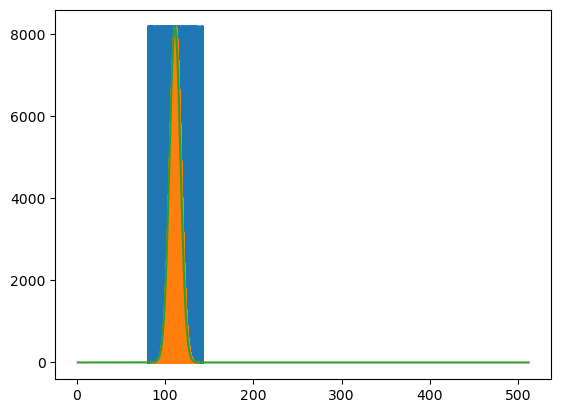

In [476]:
x = np.linspace(1, len(raw_data.iloc[:,7]), len(raw_data.iloc[:,7]))
y = raw_data.iloc[:,7]
popt, pcov = fit_gaussian(x, y)

# Definefunction that generates random x and y values within the range of x and the maximum value of the Gaussian
def monte_carlo(n_samples, *popt, no_std_dev=5):
    x_min = -no_std_dev*popt[1]+popt[0]
    x_max = no_std_dev*popt[1]+popt[0]
    x_samples = np.random.uniform(x_min, x_max, n_samples)
    y_samples = np.random.uniform(0, popt[2], n_samples)
    n_below = sum(y_samples < gaussian(x_samples, *popt))
    area = (x_max - x_min) * popt[2] * (n_below / n_samples)
    return x_samples, y_samples, area

x_samples, y_samples, area = monte_carlo(int(1e6), *popt)
print("Estimated area under the Gaussian curve:", area)

y = gaussian(x, *popt)
#plot the random samples
plt.plot(x_samples, y_samples, 'o', markersize=1)
#plot the samples below the gaussian
plt.plot(x_samples[y_samples < gaussian(x_samples, *popt)], y_samples[y_samples < gaussian(x_samples, *popt)], 'o', markersize=1)
plt.plot(x, y)
plt.show()


Fit parameters:
Peak position = 111.152 +/- 0.085
Standard deviation = 6.225 +/- 0.085
Intensity = 8192.286 +/- 96.318
Area under the Gaussian curve = 127485
Area under the original data= 125613
RMSE = 920
0.7214046154676746
25933.070244868508
29082.827434436225
22.812816994357878


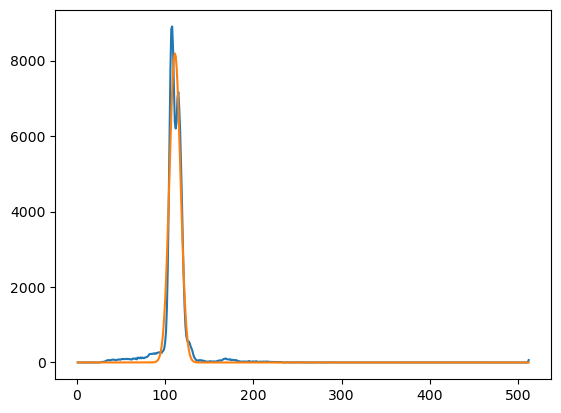

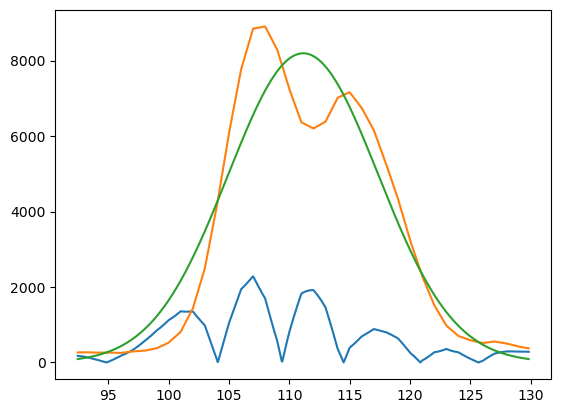

In [494]:
#interpolate y-values to match the number of x-values and corresponding to the range of x-values
x = np.linspace(1, len(raw_data.iloc[:,7]), len(raw_data.iloc[:,7]))
y = raw_data.iloc[:,7]
popt, pcov = fit_gaussian(x, y)
perr = np.sqrt(np.diag(pcov))
area, rmse, area_orig, x_interp, y_interp, x_fit, y_fit = integrate_gaussian(*popt, x_orig=x, y_orig=y)

#print the fit parameters and the area under the gaussian curve
print("Fit parameters:")
print("Peak position = {:.3f} +/- {:.3f}".format(popt[0], perr[0]))
print("Standard deviation = {:.3f} +/- {:.3f}".format(popt[1], perr[1]))
print("Intensity = {:.3f} +/- {:.3f}".format(popt[2], perr[2]))
print("Area under the Gaussian curve = {:.0f}".format(area))
print("Area under the original data= {:.0f}".format(area_orig))
print("RMSE = {:.0f}".format(rmse))
print(rmse*100/area)
print(trapz(np.sqrt((y_interp-y_fit)**2), x_interp))
print(np.sqrt(np.sum((y_interp-y_fit)**2)))
print(100*np.sqrt(np.sum((y_interp-y_fit)**2))/area)

#plot the whole gaussian curve
plt.plot(x, y)
plt.plot(x, gaussian(x, *popt))
plt.show()

#peak and residual analysis
plt.plot(x_interp, np.sqrt((y_interp-y_fit)**2))
plt.plot(x_interp, y_interp)
plt.plot(x_fit, y_fit)
plt.show()

In [495]:
import numpy as np
from scipy.integrate import quad
from scipy.optimize import curve_fit

def gaussian(x, peak_pos, std_dev, intensity):
    return intensity * np.exp(-(x - peak_pos)**2 / (2 * std_dev**2))

# Generate some example data
x = np.linspace(0, 10, 100)
y = gaussian(x, 5, 1, 1) + np.random.normal(0, 0.1, len(x))

# Fit the data to a Gaussian curve
popt, pcov = curve_fit(gaussian, x, y)

# Define the function to integrate
def gaussian_int(x):
    return gaussian(x, *popt)

# Integrate the function to get the area
area, _ = quad(gaussian_int, -np.inf, np.inf)

# Calculate the uncertainty in the area using error propagation
dpdx, dpds, dpdi = (gaussian(x, *popt) / popt[i] for i in range(3))
dxdp, dsdp, didp = (pcov[i,i] ** 0.5 for i in range(3))
darea = np.sqrt((dpdx * dxdp) ** 2 + (dpds * dsdp) ** 2 + (dpdi * didp) ** 2)

print("Area: ", area)
print("Uncertainty: ", darea)


Area:  0.039657131424652346
Uncertainty:  [2.23569025e-034 8.47231164e-026 1.78116391e-018 2.07738755e-012
 1.34413484e-007 4.82480569e-004 9.60790038e-002 1.06142382e+000
 6.50520286e-001 2.21179328e-002 4.17195771e-005 4.36563012e-009
 2.53434451e-014 8.16198967e-021 1.45827055e-028 1.44541263e-037
 7.94798904e-048 2.42456789e-059 4.10320404e-072 3.85233063e-086
 2.00648385e-101 5.79774965e-118 9.29383426e-136 8.26498488e-155
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000

[8.45090647e-02 8.45090652e-02 9.63181071e+01]
127484.59535544892
125613.15556025173
1871.4397951971914
919.6797549044974
0.7214046154676746


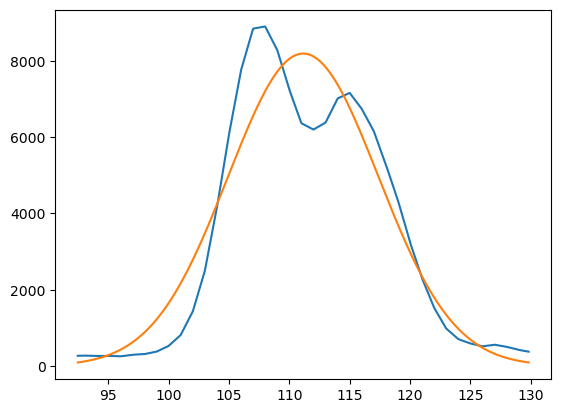

25933.070244868508
29082.827434436225
22.812816994357878
84.5023504786658


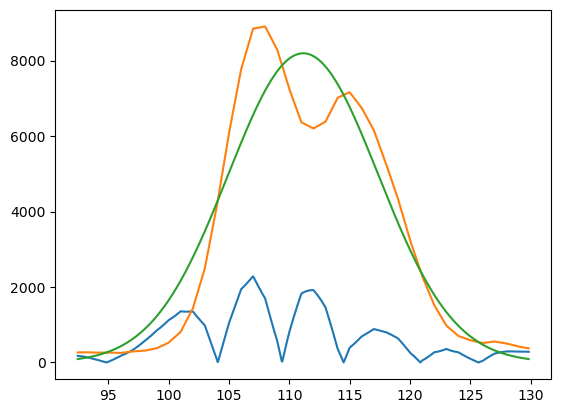

In [515]:
x = np.linspace(1, len(raw_data.iloc[:,7]), len(raw_data.iloc[:,7]))
y = raw_data.iloc[:,7]
popt, pcov = fit_gaussian(x, y)
perr = np.sqrt(np.diag(pcov))
print(perr)
area, rmse, area_orig, x_interp, y_interp, x_fit, y_fit = integrate_gaussian(*popt, x_orig=x, y_orig=y)
#plt.plot(x, y)
plt.plot(x_interp, y_interp)
plt.plot(x_fit, y_fit)
print(area)
print(area_orig)
print(area-area_orig)
print(rmse)
print(rmse*100/area)
plt.show()

plt.plot(x_interp, np.sqrt((y_interp-y_fit)**2))
plt.plot(x_interp, y_interp)
plt.plot(x_fit, y_fit)
print(trapz(np.sqrt((y_interp-y_fit)**2), x_interp))
print(np.sqrt(np.sum((y_interp-y_fit)**2)))
print(100*np.sqrt(np.sum((y_interp-y_fit)**2))/area)

def area_uncertainty(x, a, b, c, *perr):
    da, db, dc = perr
    dA_da = np.exp(-(x - b)**2 / (2 * c**2))
    dA_db = a * (x - b) / c**2 * np.exp(-(x - b)**2 / (2 * c**2))
    dA_dc = a * (x - b)**2 / c**3 * np.exp(-(x - b)**2 / (2 * c**2))
    dA = np.sum(np.sqrt((dA_da * da)**2 + (dA_db * db)**2 + (dA_dc * dc)**2))
    return dA

print(area_uncertainty(x_fit, popt[0], popt[1], popt[2], *perr))


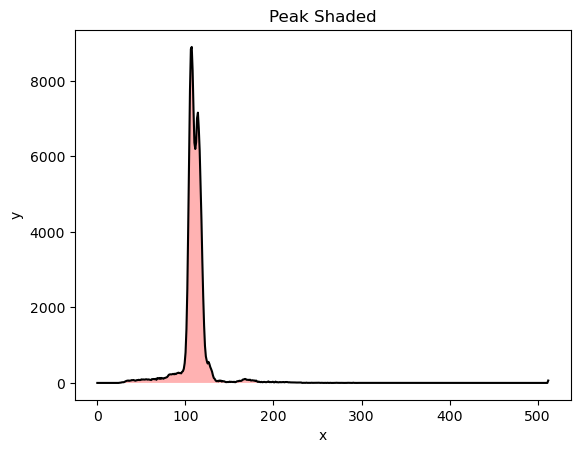

137841.72211350294


In [267]:
#function to find peak area
def peak_area(x_values, y_values):
    return sp.integrate.trapz(y_values, x_values)

def shade_peak(x, y, peak_xmin, peak_xmax, ax=None):
    """
    Shade the area under the curve between peak_xmin and peak_xmax.
    """
    if ax is None:
        ax = plt.gca()

    mask = (x >= peak_xmin) & (x <= peak_xmax)
    x_masked = np.ma.masked_where(~mask, x)
    y_masked = np.ma.masked_where(~mask, y)

    ax.fill_between(x_masked, 0, y_masked, alpha=0.3, edgecolor=None, facecolor='red')
    ax.plot(x, y, 'k-')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_title('Peak Shaded')
    plt.show()
x= np.linspace(0, len(raw_data.iloc[:,7]), len(raw_data.iloc[:,7]))
shade_peak(x,raw_data.iloc[:,7], 0, 500)
peak_area = peak_area(x,raw_data.iloc[:,7])
print(peak_area)



5.596


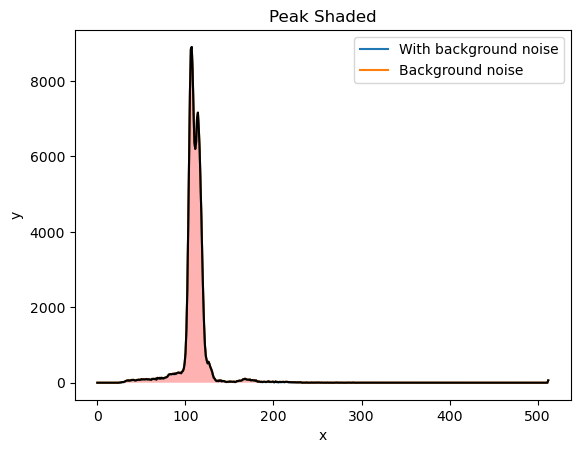

In [260]:
# Generate sample data with background noise
x= np.linspace(0, len(raw_data.iloc[:,7]), len(raw_data.iloc[:,7]))
y = raw_data.iloc[:,7]

# Calculate background noise by taking the mean of the first and last 20 points
bg_mean = np.mean(np.concatenate([y[:50], y[-200:]]))
print(bg_mean)
# Subtract background noise from y data
y -= bg_mean
#function to find peak area
def peak_area1(x_values, y_values):
    return sp.integrate.trapz(y_values, x_values)
# Plot original and adjusted data
peak_area = peak_area1(x,y)
fig, ax = plt.subplots()
ax.plot(x, y, label="With background noise")
ax.plot(x, y+bg_mean, label="Background noise")
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.legend()
shade_peak(x,raw_data.iloc[:,7], 0, 500)
plt.show()


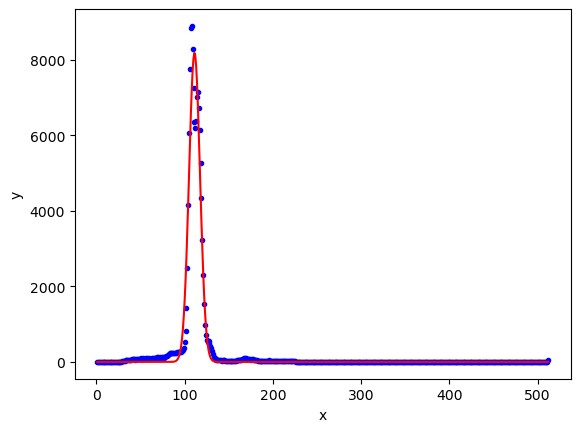

Fit parameters:
Peak position = 111.152 +/- 0.085
Standard deviation = 6.225 +/- 0.085
Intensity = 8192.286 +/- 96.318


In [251]:
x = np.linspace(1, len(raw_data.iloc[:,7]), len(raw_data.iloc[:,7]))
y = raw_data.iloc[:,7]

# Fit the data to a Gaussian curve
popt, pcov = fit_gaussian(x, y)
perr = np.sqrt(np.diag(pcov))

# Plot the data and the fit
plt.plot(x, y, 'b.')
plt.plot(x, gaussian(x, popt[0],popt[1], popt[2]), 'r-')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

print("Fit parameters:")
print("Peak position = {:.3f} +/- {:.3f}".format(popt[0], perr[0]))
print("Standard deviation = {:.3f} +/- {:.3f}".format(popt[1], perr[1]))
print("Intensity = {:.3f} +/- {:.3f}".format(popt[2], perr[2]))

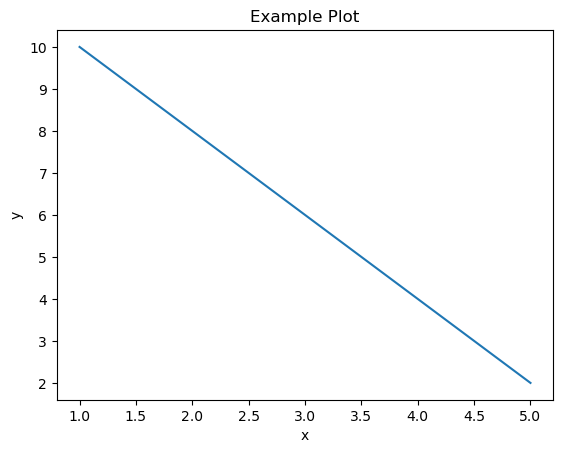

In [252]:
# Generate some example data
x = [1, 2, 3, 4, 5]
y = [10, 8, 6, 4, 2]

# Create a plot
plt.plot(x, y)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Example Plot')

# Save the plot to a folder named "plots"
result_path = "figures"
file_name = "example_plot.png"
plt.savefig(f"{result_path}/{file_name}")

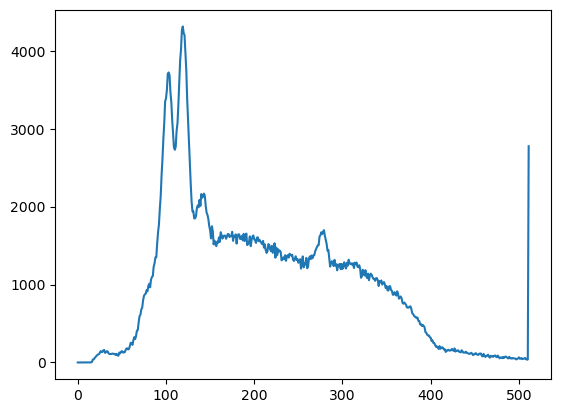

In [253]:
emission= pd.read_csv("data/emission.txt", skiprows=5, encoding="latin-1", delimiter = "	", header=None, na_filter=True, usecols=[2])
plt.plot(emission)
plt.savefig(f"{result_path}/emission.png")

C:\Users\dfmhe\AppData\Local\Temp\ipykernel_14272\2613763739.py:17: RuntimeWarning: overflow encountered in exp
  return a * np.exp(-b * x) + c


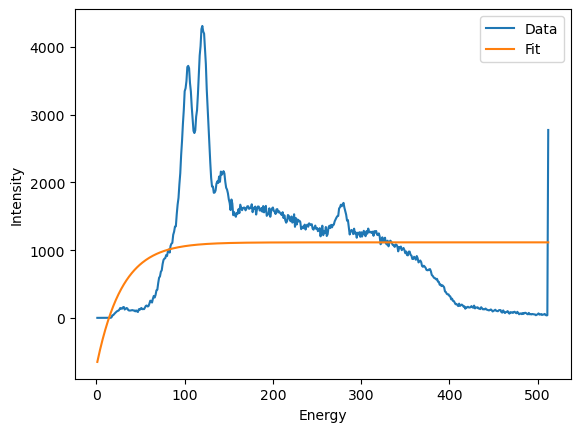

In [254]:
import numpy as np
from scipy.optimize import curve_fit

def bremsstrahlung(x, a, b, c):
    """
    Exponential curve function to fit the bremsstrahlung spectrum.

    Parameters:
        x (array): Array of x data (energy).
        a (float): Scaling factor.
        b (float): Decay rate.
        c (float): Constant offset.

    Returns:
        An array of y values corresponding to the exponential curve.
    """
    return a * np.exp(-b * x) + c

def fit_bremsstrahlung(x, y):
    """
    Fits x, y data from a bremsstrahlung spectrum measurement to an exponential curve.

    Parameters:
        x (array): Array of x data (energy).
        y (array): Array of y data (intensity).

    Returns:
        A tuple of the optimized parameters for the exponential curve: a, b, c.
    """

    # Initial guesses for the fit parameters.
    a_guess = np.max(y) - np.min(y)
    b_guess = 5
    c_guess = np.min(y)

    # Perform curve_fit.
    popt, pcov = curve_fit(bremsstrahlung, x, y, p0=[a_guess, b_guess, c_guess])

    return popt, pcov

# Generate some test data.
emission= np.array(pd.read_csv("data/emission.txt", skiprows=5, encoding="latin-1", delimiter = "	", header=None, na_filter=True, usecols=[2]).to_numpy(dtype=float)).flatten()

# Fit the data to an exponential curve.
x = np.arange(len(emission)) + 1
popt, pcov = fit_bremsstrahlung(x, emission)

# Plot the data and the fitted curve.

plt.plot(x, emission, label='Data')
plt.plot(x, bremsstrahlung(x, *popt), label='Fit')
plt.xlabel('Energy')
plt.ylabel('Intensity')
plt.legend()
plt.show()